In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

### Part 1: Compute Best-Level OFI per Minute

In [2]:
df = pd.read_csv('first_25000_rows.csv')

# Parse the exchange event timestamp and sort
df['ts_event_dt'] = pd.to_datetime(df['ts_event'])
df.sort_values(['symbol', 'ts_event_dt'], inplace=True)

best_ofi_records = []

# Iterate over each stock symbol
for symbol, df_sym in df.groupby('symbol'):
    # Initialize previous best bid/ask snapshot
    prev_bid_px = df_sym.iloc[0]['bid_px_00']
    prev_bid_sz = df_sym.iloc[0]['bid_sz_00']
    prev_ask_px = df_sym.iloc[0]['ask_px_00']
    prev_ask_sz = df_sym.iloc[0]['ask_sz_00']
    
    # Set up minute-level accumulator
    current_minute = df_sym['ts_event_dt'].dt.floor('min').iloc[0]
    ofi_acc = 0
    
    # Loop through events chronologically
    for _, row in df_sym.iterrows():
        minute = row['ts_event_dt'].floor('min')
        
        # On new minute, record the previous minute's OFI and reset
        if minute != current_minute:
            best_ofi_records.append({
                'symbol': symbol,
                'minute': current_minute,
                'ofi_best': ofi_acc
            })
            current_minute = minute
            ofi_acc = 0
        
        # Read current best bid/ask
        bid_px, bid_sz = row['bid_px_00'], row['bid_sz_00']
        ask_px, ask_sz = row['ask_px_00'], row['ask_sz_00']
        
        # Compute bid-side OFI contribution
        if bid_px > prev_bid_px:
            ofi_acc += bid_sz
        elif bid_px == prev_bid_px:
            ofi_acc += (bid_sz - prev_bid_sz)
        else:
            ofi_acc -= bid_sz
        
        # Compute ask-side OFI contribution
        if ask_px < prev_ask_px:
            ofi_acc -= ask_sz
        elif ask_px == prev_ask_px:
            ofi_acc -= (ask_sz - prev_ask_sz)
        else:
            ofi_acc += ask_sz
        
        # Update previous snapshot
        prev_bid_px, prev_bid_sz = bid_px, bid_sz
        prev_ask_px, prev_ask_sz = ask_px, ask_sz
    
    # Capture the last minute for this symbol
    best_ofi_records.append({
        'symbol': symbol,
        'minute': current_minute,
        'ofi_best': ofi_acc
    })

# Convert to DataFrame
df_best_ofi = pd.DataFrame(best_ofi_records)

# Display the first few rows
from IPython.display import display
display(df_best_ofi.head())


,symbol,minute,ofi_best
0,AAPL,2024-10-21 11:54:00+00:00,-531
1,AAPL,2024-10-21 11:55:00+00:00,-1217
2,AAPL,2024-10-21 11:56:00+00:00,334
3,AAPL,2024-10-21 11:57:00+00:00,960
4,AAPL,2024-10-21 11:58:00+00:00,615


,count,mean,std,min,10%,25%,50%,75%,90%,max
ofi_best,71.0,-1000.366197,1541.346111,-6296.0,-3507.0,-1557.5,-414.0,54.5,334.0,978.0


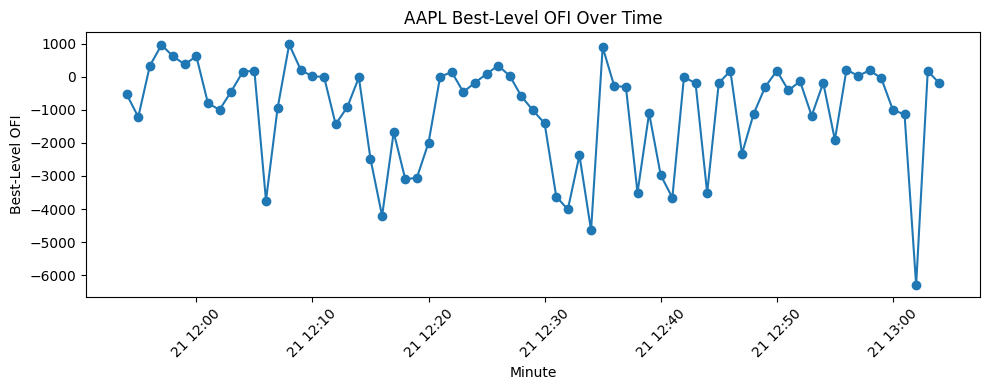

In [3]:
#Summary statistics for Best-Level OFI
summary = df_best_ofi['ofi_best'].describe(percentiles=[.1, .25, .5, .75, .9])
summary_df = summary.to_frame().T
display(summary_df)

#Time series plot for AAPL (since only AAPL is present)
aapl_ofi = df_best_ofi[df_best_ofi['symbol'] == 'AAPL']

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(aapl_ofi['minute'], aapl_ofi['ofi_best'], marker='o', linestyle='-')
ax.set_title('AAPL Best-Level OFI Over Time')
ax.set_xlabel('Minute')
ax.set_ylabel('Best-Level OFI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Part 2: Multi-Level OFI

In [4]:
multi_ofi_records = []

for symbol, df_sym in df.groupby('symbol'):
    df_sym = df_sym.reset_index(drop=True)
    # Initialize previous full-snapshot (levels 00–09)
    prev = df_sym.loc[0]
    # Initialize per-minute accumulators
    current_minute = prev['ts_event_dt'].floor('min')
    ofi_acc = [0]*10
    
    for _, row in df_sym.iterrows():
        minute = row['ts_event_dt'].floor('min')
        # On new minute, record and reset
        if minute != current_minute:
            rec = {'symbol': symbol, 'minute': current_minute}
            for m in range(10):
                rec[f'ofi_level{m+1}'] = ofi_acc[m]
            multi_ofi_records.append(rec)
            current_minute = minute
            ofi_acc = [0]*10
        
        # Compute per-level OFI contributions
        for m in range(10):
            # previous and current bid/ask at level m
            pbp, pbs = prev[f'bid_px_{m:02d}'], prev[f'bid_sz_{m:02d}']
            pap, pas = prev[f'ask_px_{m:02d}'], prev[f'ask_sz_{m:02d}']
            cbp, cbs = row[f'bid_px_{m:02d}'], row[f'bid_sz_{m:02d}']
            cap, cas = row[f'ask_px_{m:02d}'], row[f'ask_sz_{m:02d}']
            
            # bid-side
            if cbp > pbp:
                of_b = cbs
            elif cbp == pbp:
                of_b = cbs - pbs
            else:
                of_b = -cbs
            # ask-side
            if cap > pap:
                of_a = -cas
            elif cap == pap:
                of_a = cas - pas
            else:
                of_a = cas
            
            ofi_acc[m] += (of_b - of_a)
        
        prev = row
    
    # Flush last minute
    rec = {'symbol': symbol, 'minute': current_minute}
    for m in range(10):
        rec[f'ofi_level{m+1}'] = ofi_acc[m]
    multi_ofi_records.append(rec)

df_multi_ofi = pd.DataFrame(multi_ofi_records)
display(df_multi_ofi.head())

,symbol,minute,ofi_level1,ofi_level2,ofi_level3,ofi_level4,ofi_level5,ofi_level6,ofi_level7,ofi_level8,ofi_level9,ofi_level10
0,AAPL,2024-10-21 11:54:00+00:00,-531,346,542,-156,-61,580,44,-247,677,590
1,AAPL,2024-10-21 11:55:00+00:00,-1217,1767,1821,-236,-380,738,-789,161,1388,-580
2,AAPL,2024-10-21 11:56:00+00:00,334,-573,1897,-585,652,-272,-64,850,-144,253
3,AAPL,2024-10-21 11:57:00+00:00,960,653,335,205,-1765,986,-504,-379,1667,-235
4,AAPL,2024-10-21 11:58:00+00:00,615,18,1047,590,-41,-1183,1191,-111,567,2455


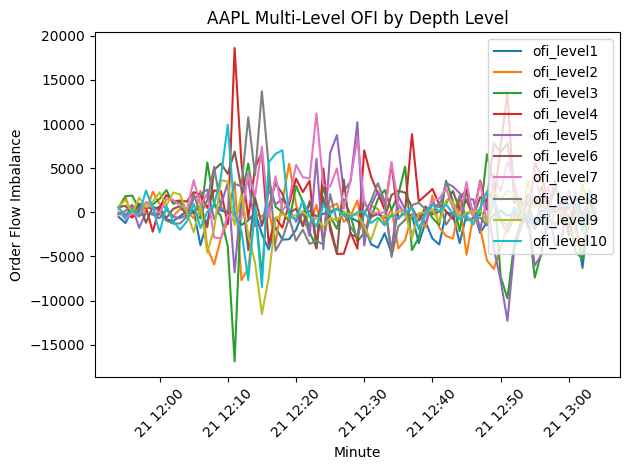

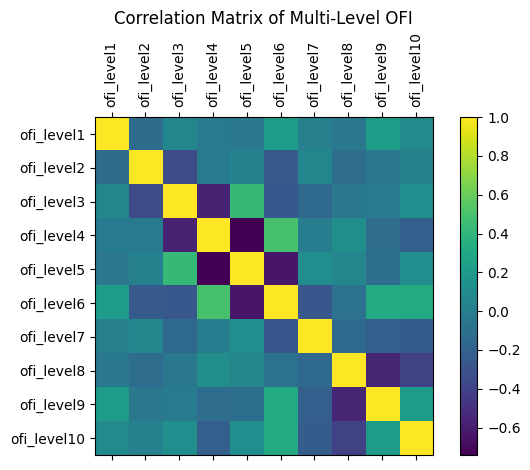

In [5]:
df_ml_aapl = df_multi_ofi[df_multi_ofi['symbol'] == 'AAPL'].set_index('minute')

# Define level columns
levels = [f'ofi_level{i}' for i in range(1, 11)]

# 1) Line plot of Multi-Level OFI over time
fig, ax = plt.subplots()
for lvl in levels:
    ax.plot(df_ml_aapl.index, df_ml_aapl[lvl], label=lvl)
ax.set_title('AAPL Multi-Level OFI by Depth Level')
ax.set_xlabel('Minute')
ax.set_ylabel('Order Flow Imbalance')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 2) Correlation heatmap of Multi-Level OFI
corr = df_ml_aapl[levels].corr()
fig, ax = plt.subplots()
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticks(range(10))
ax.set_xticklabels(levels, rotation=90)
ax.set_yticks(range(10))
ax.set_yticklabels(levels)
ax.set_title('Correlation Matrix of Multi-Level OFI')
plt.tight_layout()
plt.show()

### Part 3: Multi-Level OFI

,symbol,minute,ofi_integrated
0,AAPL,2024-10-21 11:54:00+00:00,-1630.430916
1,AAPL,2024-10-21 11:55:00+00:00,-1934.939660
2,AAPL,2024-10-21 11:56:00+00:00,-3145.735035
3,AAPL,2024-10-21 11:57:00+00:00,-197.122877
4,AAPL,2024-10-21 11:58:00+00:00,-2055.089653


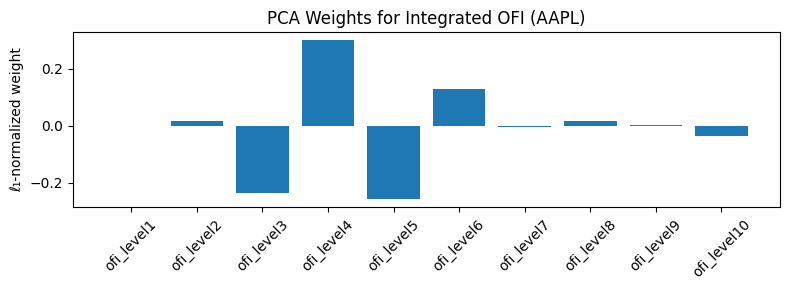

In [6]:
from sklearn.decomposition import PCA

# Part 3: Compute Integrated OFI via PCA
integrated = []

levels = [f'ofi_level{i}' for i in range(1, 11)]

for symbol, grp in df_multi_ofi.groupby('symbol'):
    # Extract the multi-level OFI matrix (rows × 10 levels)
    X = grp[levels].fillna(0).values
    
    # Fit PCA and get first principal component
    pca = PCA(n_components=1)
    comp1 = pca.fit_transform(X).flatten()
    
    # Retrieve and ℓ1-normalize the PCA weights
    weights = pca.components_[0]
    weights_norm = weights / np.sum(np.abs(weights))
    
    # Append integrated OFI and weights to the group
    grp = grp.copy()
    grp['ofi_integrated'] = comp1
    grp['symbol'] = symbol
    integrated.append((grp, weights_norm))

# Concatenate back
df_integrated = pd.concat([g for g, w in integrated], ignore_index=True)

# Display first rows
display(df_integrated[['symbol','minute','ofi_integrated']].head())

# Plot PCA weights for the first (and only) symbol
weights_norm = integrated[0][1]
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(levels, weights_norm)
ax.set_title(f"PCA Weights for Integrated OFI ({integrated[0][0]['symbol'].iloc[0]})")
ax.set_ylabel("ℓ₁-normalized weight")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


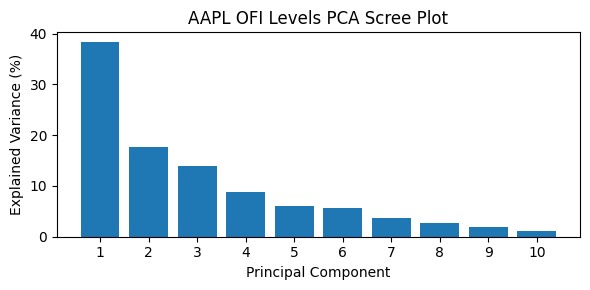

In [7]:
levels = [f'ofi_level{i}' for i in range(1,11)]
X = df_multi_ofi[df_multi_ofi['symbol']=='AAPL'][levels].fillna(0).values

pca_full = PCA(n_components=10).fit(X)
evr = pca_full.explained_variance_ratio_

plt.figure(figsize=(6,3))
plt.bar(range(1,11), evr*100)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('AAPL OFI Levels PCA Scree Plot')
plt.xticks(range(1,11))
plt.tight_layout()
plt.show()

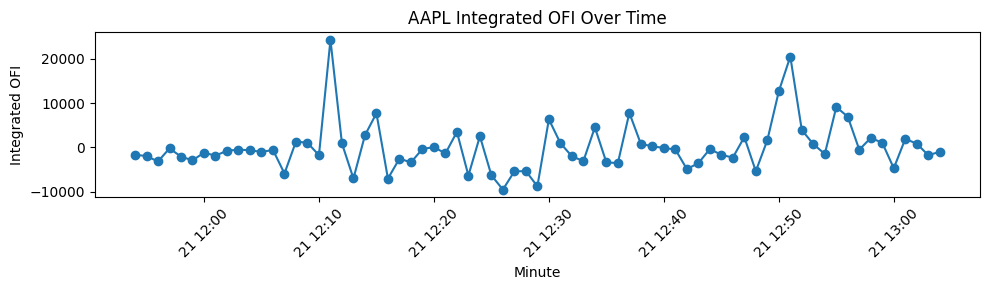

In [9]:
df_int_aapl = df_integrated[df_integrated['symbol']=='AAPL']

plt.figure(figsize=(10,3))
plt.plot(df_int_aapl['minute'], df_int_aapl['ofi_integrated'], marker='o', linestyle='-')
plt.title('AAPL Integrated OFI Over Time')
plt.xlabel('Minute')
plt.ylabel('Integrated OFI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

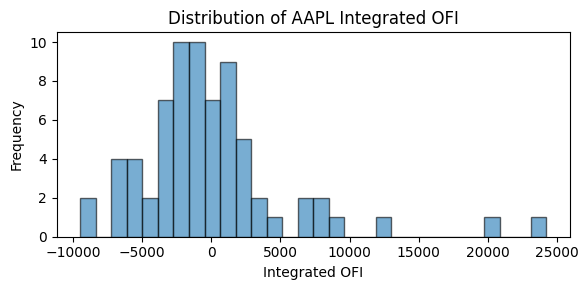

In [10]:
plt.figure(figsize=(6,3))
plt.hist(df_int_aapl['ofi_integrated'], bins=30, edgecolor='k', alpha=0.6)
plt.title('Distribution of AAPL Integrated OFI')
plt.xlabel('Integrated OFI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


###  Part 4: Cross-Asset OFI Matrix (Integrated)

In [23]:
df_cross_ofi = df_integrated.pivot(index='minute', columns='symbol', values='ofi_integrated').fillna(0)

# Display the first few rows
display(df_cross_ofi.head())

# If multiple symbols are present, visualize the cross-asset correlation:
if df_cross_ofi.shape[1] > 1:
    corr_matrix = df_cross_ofi.corr()
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.matshow(corr_matrix)
    fig.colorbar(cax)
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns, rotation=90)
    ax.set_yticks(range(len(corr_matrix.index)))
    ax.set_yticklabels(corr_matrix.index)
    ax.set_title('Cross-Asset Integrated OFI Correlation', pad=20)
    plt.tight_layout()
    plt.show()

symbol,AAPL
minute,
2024-10-21 11:54:00+00:00,-1630.430916
2024-10-21 11:55:00+00:00,-1934.939660
2024-10-21 11:56:00+00:00,-3145.735035
2024-10-21 11:57:00+00:00,-197.122877
2024-10-21 11:58:00+00:00,-2055.089653


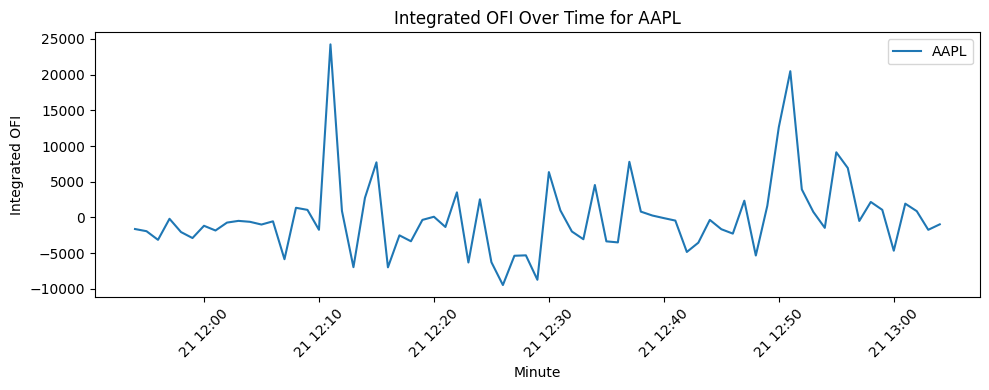

In [24]:
symbols = df_cross_ofi.columns.tolist()
n_plot = min(3, len(symbols))
plt.figure(figsize=(10, 4))
for sym in symbols[:n_plot]:
    plt.plot(df_cross_ofi.index, df_cross_ofi[sym], label=sym)
plt.title('Integrated OFI Over Time for AAPL')
plt.xlabel('Minute')
plt.ylabel('Integrated OFI')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

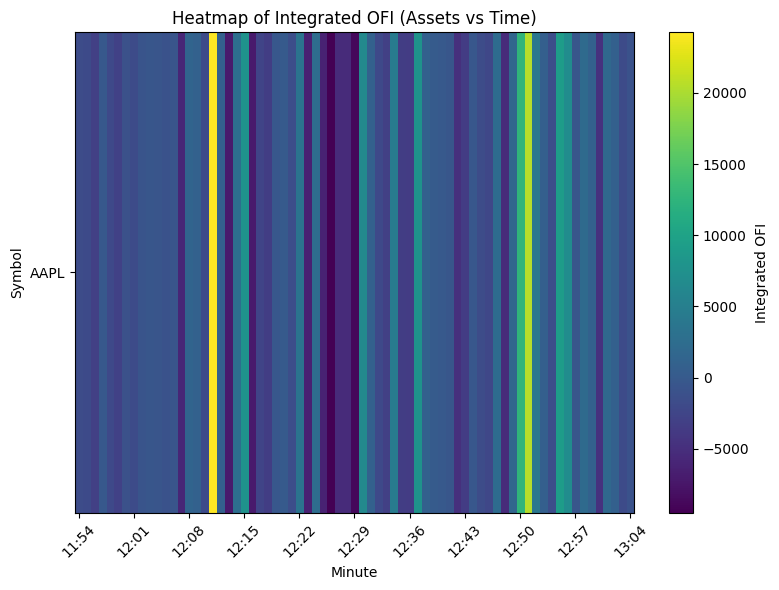

In [25]:
plt.figure(figsize=(8, 6))
# convert to 2D array: time x symbols
data = df_cross_ofi.T  # symbols x time
cax = plt.imshow(data, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(cax, label='Integrated OFI')
plt.yticks(range(len(symbols)), symbols)
plt.xticks(range(0, data.shape[1], max(1, data.shape[1]//10)), 
           [df_cross_ofi.index[i].strftime('%H:%M') for i in range(0, data.shape[1], max(1, data.shape[1]//10))],
           rotation=45)
plt.title('Heatmap of Integrated OFI (Assets vs Time)')
plt.xlabel('Minute')
plt.ylabel('Symbol')
plt.tight_layout()
plt.show()